In [2]:
import numpy as np
import urllib.request
import pandas as pd 
import requests, zipfile, io
from datetime import datetime, timedelta, timezone
from zipfile import ZipFile
from bs4 import BeautifulSoup
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from geopy import distance

import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import metpy.calc as mcalc

In [3]:
def lat_lon_2D_index(y,x,lat1,lon1):
    '''This function calculates the distance from a desired 
    lat/lon point to each element of a 2D array of lat/lon values,
    typically from model output, and determines the index value 
    corresponding to the nearest lat/lon grid point.
    
    x = longitude array
    y = latitude array
    lon1 = longitude point (single value)
    lat1 = latitude point (single value)
    
    Returns the two index values for nearest lat, lon 
    point on grid for grids (y,x)
    
    Equations for variable distance between longitudes from
    http://andrew.hedges.name/experiments/haversine/'''
    
    R = 6373.*1000.  # Earth's Radius in meters
    rad = np.pi/180.
    x1 = np.ones(x.shape)*lon1
    y1 = np.ones(y.shape)*lat1
    dlon = np.abs(x-x1)
    dlat = np.abs(y-y1)
    a = (np.sin(rad*dlat/2.))**2 + \
         np.cos(rad*y1) * np.cos(rad*y) * (np.sin(rad*dlon/2.))**2 
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
    d = R * c
    return np.unravel_index(d.argmin(), d.shape)

In [4]:
## Creating a hail dataset from the NCEI storm event database
dir_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles'
ext = '.csv.gz'

def listFD(url, ext=''):
    page = requests.get(url).text
    #print(file)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

# The years we want to analyze
year_list = [str(i) for i in range(2018,2022)]

li = []

for file in listFD(dir_url, ext):
    if any(year in file[:98] for year in year_list) & ('details' in file): ## any years between 2018 and 2022 and the correct file type
        print(file)
        df = pd.read_csv(file)#, compression = 'gzip'), #index_col=None, )
        
        hail_df = pd.DataFrame(df.loc[df['EVENT_TYPE'] == 'Hail']) ## only want hail reports
        li.append(hail_df)
df_hail = pd.concat(li, axis=0, ignore_index=True)  

hail_datetimes = np.array([])

offset = [int(i.split('-')[1]) for i in df_hail['CZ_TIMEZONE']] ## the timezone offset for later use?

## Creating array of datetimes of hail events 
for i in range(0,len(df_hail['BEGIN_TIME'])): 
    mtime        = str(np.array(df_hail['BEGIN_TIME'])[i])
    if len(mtime)<4:
        nz = 4 - len(mtime)
        nZ = '0'*nz
        mtime = nZ + mtime
    check_date = datetime(int(str(np.array(df_hail['BEGIN_YEARMONTH'])[i])[:4]), \
                     int(str(np.array(df_hail['BEGIN_YEARMONTH'])[i])[-2:]), \
                     int(str(np.array(df_hail['BEGIN_DAY'])[i])),           \
                     int(mtime[:-2]),     \
                     int(mtime[-2:])) + timedelta(hours = offset[i])
    hail_datetimes = np.append(hail_datetimes, check_date)

df_hail['Datetime'] = hail_datetimes
df_hail = df_hail.sort_values(by=['Datetime'], ignore_index = True)

## other possible useful information
hail_sizes = df_hail['MAGNITUDE']
hail_lats  = df_hail['BEGIN_LAT']
hail_lons  = df_hail['BEGIN_LON']

https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2018_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2019_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2020_c20220322.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2021_c20220616.csv.gz


In [4]:
from geopy import distance

## function that finds all hail reports within 30 minutes and 90 kilometers, returns the index of the largest hail report
def distance_time_check(df, index):
    
    datt = df['Datetime'].astype('object')
    lats = df['BEGIN_LAT']
    lons = df['BEGIN_LON']
    
    dtime = 30
    within_minutes = np.where((datt >= datt[index]) & (datt < datt[index] + timedelta(minutes = 30)))[0]
    mag_list,lat_list, lon_list, date_list, dist_list, index_list = np.array([]),np.array([]),np.array([]),np.array([]), np.array([]), np.array([])
    case_latlon = (lats[index], lons[index])
    #print(within_minutes.shape)

    for j in within_minutes:
        
        delta_d = 90
        
        if distance.distance(case_latlon, (lats[j], lons[j])).km < delta_d: ## Checking if case is within 90km of the case in question
            mag_list  = np.append(mag_list, df['MAGNITUDE'][j])
            index_list= np.append(index_list, j)
            lat_list  = np.append(lat_list, lats[j])
            lon_list  = np.append(lon_list, lons[j])
            date_list = np.append(date_list, datt[j])
            dist_list = np.append(dist_list, distance.distance(case_latlon, (lats[j], lons[j])).km)
            
    #print(mag_list.shape)      
    max_w = np.where(mag_list == mag_list.max())[0]
    df_index = index_list[max_w][0]
    
    return df_index, index_list, lats, lons, within_minutes, lat_list, lon_list, lats[index], lons[index]

In [4]:
# df_hail_no_repeats = pd.read_pickle("df_hail_no_repeats.pkl")
# df_hail_no_repeats = df_hail_no_repeats.reset_index(drop = True)


## creating a hail dataset with only the strongest report within 30 minutes and 90 km
## this effectively picks the "strongest" hail from a single storm

df_hail_no_repeats = df_hail

t = 0
x = True
i = 0
i_array = np.array([])

while i != df_hail_no_repeats.index.max():
    print(i)
    print(df_hail['Datetime'][i])
    
    df_coord = np.array(df_hail_no_repeats.index)
    
    df_index, index_list, lats, lons, within_minutes, lat_list, lon_list, hail_lat, hail_lon = distance_time_check(df_hail, i)
    print('keeping index', df_index)
    i_array = np.append(i_array, df_index)
    
    remove_indices = index_list[np.where(index_list != df_index)[0]] ## indices of smaller hail that should be removed
    print(remove_indices)
    #print('removing index', remove_indices)
    #print(remove_indices)
    i_array = np.append(i_array, remove_indices)
    try:
        #print(df_hail_no_repeats['Datetime'][remove_indices])
        df_hail_no_repeats = df_hail_no_repeats.drop(remove_indices, errors = 'ignore')
    except:
        print('didnt drop')
        pass
    i = df_coord[~np.isin(df_coord, i_array)].min()
    #print(df_coord[~np.isin(df_coord, i_array)])


0
2018-01-11 21:57:00


NameError: name 'distance_time_check' is not defined

In [7]:
# df_hail_no_repeats = df_hail_no_repeats.reset_index(drop = True)
# df_hail_no_repeats.to_pickle("df_hail_no_repeats.pkl")

In [14]:
# df_hail_no_repeats = pd.read_pickle("df_hail_no_repeats.pkl")
# #df_hail_no_repeats = df_hail_no_repeats.reset_index(drop = True)

# ## some quality control checks, not very important
# datt = df_hail_no_repeats['Datetime'].astype('object')
# lats = df_hail_no_repeats['BEGIN_LAT']
# lons = df_hail_no_repeats['BEGIN_LON']

# for i in range(0,len(df_hail_no_repeats)):
#     #print(i)
#     within_minutes = np.where((datt >= datt[i]) & (datt < datt[i] + timedelta(minutes = 30)))[0]
#     mag_list,lat_list, lon_list, date_list, dist_list, index_list = np.array([]),np.array([]),np.array([]),np.array([]), np.array([]), np.array([])
#     case_latlon = (lats[i], lons[i])
    
#     for j in within_minutes:

#         delta_d = 90

#         if distance.distance(case_latlon, (lats[j], lons[j])).km < delta_d: ## Checking if case is within 90 km of the case in question
#             #print('true')
#             mag_list  = np.append(mag_list, df_hail_no_repeats['MAGNITUDE'][j])
#             index_list= np.append(index_list, j)
#             lat_list  = np.append(lat_list, lats[j])
#             lon_list  = np.append(lon_list, lons[j])
#             date_list = np.append(date_list, datt[j])
#             dist_list = np.append(dist_list, distance.distance(case_latlon, (lats[j], lons[j])).km)
#     if mag_list.shape[0]>2:
#         print(i)
#         print(date_list)
#         print(mag_list)
#         print(dist_list)
    

134
[Timestamp('2018-03-17 23:35:00') Timestamp('2018-03-17 23:48:00')
 Timestamp('2018-03-18 00:00:00')]
[1.5  1.75 1.  ]
[ 0.         46.85885988 51.07055744]
193
[Timestamp('2018-03-19 23:30:00') Timestamp('2018-03-19 23:39:00')
 Timestamp('2018-03-19 23:40:00') Timestamp('2018-03-19 23:40:00')]
[4.   1.25 2.5  2.5 ]
[ 0.         27.95940705 77.20599707 77.46165101]
212
[Timestamp('2018-03-20 18:45:00') Timestamp('2018-03-20 18:50:00')
 Timestamp('2018-03-20 19:00:00') Timestamp('2018-03-20 19:05:00')]
[1.   1.   2.   1.75]
[ 0.          1.10889526 12.15976919 24.45867258]
213
[Timestamp('2018-03-20 18:50:00') Timestamp('2018-03-20 19:00:00')
 Timestamp('2018-03-20 19:05:00')]
[1.   2.   1.75]
[ 0.         11.80112122 25.37215378]
230
[Timestamp('2018-03-24 00:37:00') Timestamp('2018-03-24 00:38:00')
 Timestamp('2018-03-24 00:55:00')]
[0.75 1.75 1.  ]
[ 0.         66.98628183 35.98919715]
306
[Timestamp('2018-04-03 19:42:00') Timestamp('2018-04-03 19:58:00')
 Timestamp('2018-04-03 2

In [9]:
%matplotlib widget
map_crs = ccrs.LambertConformal(central_longitude=-98,
                               central_latitude=35,
                               standard_parallels=(30, 60))
data_crs = ccrs.PlateCarree()

fig = plt.figure(1)#, figsize=(8,6))
ax = plt.subplot(1, 1, 1, projection=map_crs)
ax.set_extent([lons[within_minutes].min()-3, lons[within_minutes].max()+3,lats[within_minutes].min()-3, lats[within_minutes].max()+3], data_crs)
#ax.add_feature(cfeature.OCEAN, facecolor='lightskyblue') 
               #edgecolor='deepskyblue', linewidth=10)
#ax.add_feature(cfeature.LAKES, facecolor='lightskyblue', zorder=0)
ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'], linewidth=1, edgecolor='k')
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1)
#plt.scatter(lons[i], lats[i], transform = ccrs.PlateCarree(), s = 100)
plt.scatter(lons[within_minutes], lats[within_minutes], transform = ccrs.PlateCarree(), s = 50, color = 'r')
plt.scatter(lon_list, lat_list, transform = ccrs.PlateCarree(), s = 50, color = 'b')
plt.scatter(hail_lon, hail_lat, transform = ccrs.PlateCarree(), s = 40, color ='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [6]:
## picks whether we'll be using meso sector 1 or 2 from goes

def meso_sector_define(datetime, hail_lat, hail_lon):
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    bucket_name  = 'noaa-goes16'   ## data we want
    product_name = 'ABI-L1b-RadM1' ## mesoscale sector 1
    year         = datetime.year
    version6     = 6
    version3     = 3
    day_of_year  = datetime.timetuple().tm_yday
    hour         = datetime.hour
    minute       = datetime.minute
    month        = datetime.month
    day          = datetime.day
    band_vapor   = 8
    band_wnd     = 14
    
    file_merra     = f'/data/jtrapp/a/jamessg3/MERRA2/MERRA2_400.inst1_2d_asm_Nx.{year}{month:02.0f}{day:02.0f}.nc4'
    file_merra_401 = f'/data/jtrapp/a/jamessg3/MERRA2/MERRA2_401.inst1_2d_asm_Nx.{year}{month:02.0f}{day:02.0f}.nc4'
    
    ## Variables needed from GOES-16 files
    variables = ['planck_fk1','planck_bc1','planck_fk2','planck_bc2','Rad', 'goes_imager_projection']

    keys_vap6 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version6}C{band_vapor:02.0f}'
                    )
    keys_wnd6 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version6}C{band_wnd:02.0f}'
                    )
    keys_vap3 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version3}C{band_vapor:02.0f}'
                    )
    keys_wnd3 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version3}C{band_wnd:02.0f}'
                    )
    

    ## try a visible channel 
    try:
        keys_vap = [key for key in keys_vap6] 
        keys_wnd = [key for key in keys_wnd6]
    except:
        keys_vap = [key for key in keys_vap3] 
        keys_wnd = [key for key in keys_wnd3]
    

    if np.size(keys_vap) != np.size(keys_wnd):
        print('incorrect number of files')
        return 'ABI-L1b-RadM1'

    start_min = [int(i.split('_')[-3][-5:-3]) for i in keys_vap]
    dt        = 1
    within    = np.where((np.array(start_min) > minute-dt) & (minute+dt > np.array(start_min)))[0]
    keys_vap = np.array(keys_vap)[within]
    keys_wnd = np.array(keys_wnd)[within]


    list_vap = []
    list_wnd = []

    for i in range(0, 1):
        resp_vap = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{keys_vap[i]}')
        file_name_vap = keys_vap[i].split('/')[-1].split('.')[0]
        ncds_vap = netCDF4.Dataset(file_name_vap, memory = resp_vap.content)
        store_vap  = xr.backends.NetCDF4DataStore(ncds_vap)

        ds_vap_single     = xr.open_dataset(store_vap)

        lat,lon = radian_to_latlon(ds_vap_single)

        g16_lati, g16_loni = lat_lon_2D_index(lat,lon,hail_lat,hail_lon)

        if ((hail_lon>lon[g16_lati,:].min()) & (hail_lon<lon[g16_lati,:].max())) & ((hail_lat>lat[:,g16_loni].min()) & (hail_lat<lat[:,g16_loni].max())):
            print('Using mesoscale 1')
            return 'ABI-L1b-RadM1'
        else:
            print('Trying mesoscale 2')
            return 'ABI-L1b-RadM2'

In [7]:
# datet = datetime(2018, 2, 6, 22, 29)
# hail_lat = np.array(df_hail['BEGIN_LAT'])[50]
# hail_lon = np.array(df_hail['BEGIN_LON'])[50]
# print(datet)

# s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
# bucket_name  = 'noaa-goes16'   ## data we want
# product_name  = meso_sector_define(datet, hail_lat, hail_lon) ## mesoscale sector definition
# year         = datet.year
# version6     = 6
# version3     = 3
# day_of_year  = datet.timetuple().tm_yday
# hour         = datet.hour
# minute       = datet.minute
# print(minute)
# dt = 15

# if minute - dt < 0:
#     n = 0-(minute-dt)
#     print(n)
#     datet_m1 = datet-timedelta(hours = 1)
#     year_m1  = datet_m1.year
#     day_of_year_m1 = datet_m1.timetuple().tm_yday
#     hour_m1  = datet_m1.hour
#     print('poo poo')
# if minute + dt > 60:
#     n = (minute+dt)-60
#     datetime_p1 = datetime + timedelta(hours = 1)
#     year_p1  = datet_p1.year
#     day_of_year_p1 = datet_p1.timetuple().tm_yday
#     hour_p1 = datet_p1.hour
    
# month        = datet.month
# day          = datet.day
# band_vapor   = 8
# band_wnd     = 14

# # ## Variables needed from GOES-16 files
# variables = ['planck_fk1','planck_bc1','planck_fk2','planck_bc2','Rad', 'goes_imager_projection']

# try:
#     keys_vap6 = get_s3_keys(bucket_name,
#                    s3_client,
#                    prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version6}C{band_vapor:02.0f}'
#                     )
#     keys_wnd6 = get_s3_keys(bucket_name,
#                    s3_client,
#                    prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version6}C{band_wnd:02.0f}'
#                     )
#     ## Less than or greater than 1 hour for keys version 6
#     if minute - dt < 0:
#             keys_vap6_m1 = get_s3_keys(bucket_name,
#                    s3_client,
#                    prefix = f'{product_name[:-1]}/{year_m1}/{day_of_year_m1:03.0f}/{hour_m1:02.0f}/OR_{product_name}-M{version6}C{band_vapor:02.0f}'
#                     )
#             keys_wnd6_m1 = get_s3_keys(bucket_name,
#                    s3_client,
#                    prefix = f'{product_name[:-1]}/{year_m1}/{day_of_year_m1:03.0f}/{hour_m1:02.0f}/OR_{product_name}-M{version6}C{band_wnd:02.0f}'
#                         )
#     if minute + dt > 60:
#         keys_vap6_p1 = get_s3_keys(bucket_name,
#                s3_client,
#                prefix = f'{product_name[:-1]}/{year_p1}/{day_of_year_p1:03.0f}/{hour_p1:02.0f}/OR_{product_name}-M{version6}C{band_vapor:02.0f}'
#                 )
#         keys_wnd6_p1 = get_s3_keys(bucket_name,
#                s3_client,
#                prefix = f'{product_name[:-1]}/{year_p1}/{day_of_year_p1:03.0f}/{hour_p1:02.0f}/OR_{product_name}-M{version6}C{band_wnd:02.0f}'
#                     )        

#     keys_vap3 = get_s3_keys(bucket_name,
#                    s3_client,
#                    prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version3}C{band_vapor:02.0f}'
#                     )
#     keys_wnd3 = get_s3_keys(bucket_name,
#                    s3_client,
#                    prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version3}C{band_wnd:02.0f}'
#                            )
#     ## Less than or greater than 1 hour for keys version       
#     if minute - dt < 0:
#         keys_vap3_m1 = get_s3_keys(bucket_name,
#                s3_client,
#                prefix = f'{product_name[:-1]}/{year_m1}/{day_of_year_m1:03.0f}/{hour_m1:02.0f}/OR_{product_name}-M{version3}C{band_vapor:02.0f}'
#                 )
#         keys_wnd3_m1 = get_s3_keys(bucket_name,
#                s3_client,
#                prefix = f'{product_name[:-1]}/{year_m1}/{day_of_year_m1:03.0f}/{hour_m1:02.0f}/OR_{product_name}-M{version3}C{band_wnd:02.0f}'
#                     )
#     if minute + dt > 60:
#         keys_vap3_p1 = get_s3_keys(bucket_name,
#                s3_client,
#                prefix = f'{product_name[:-1]}/{year_p1}/{day_of_year_p1:03.0f}/{hour_p1:02.0f}/OR_{product_name}-M{version3}C{band_vapor:02.0f}'
#                 )
#         keys_wnd3_p1 = get_s3_keys(bucket_name,
#                s3_client,
#                prefix = f'{product_name[:-1]}/{year_p1}/{day_of_year_p1:03.0f}/{hour_p1:02.0f}/OR_{product_name}-M{version3}C{band_wnd:02.0f}'
#                     )    
        
#     ## try a visible channel 
#     try:
#         keys_vap = [key for key in keys_vap6] 
#         keys_wnd = [key for key in keys_wnd6]
        
#         if minute - dt < 0:
#             keys_vap_m1 = np.array([key for key in keys_vap6_m1][-n:])
#             keys_wnd_m1 = np.array([key for key in keys_wnd6_m1][-n:])
#         if minute + dt > 60:
#             keys_vap_p1 = np.array([key for key in keys_vap6_p1][0:n])
#             keys_wnd_p1 = np.array([key for key in keys_wnd6_p1][0:n])
        
#     except:
#         keys_vap = [key for key in keys_vap3] 
#         keys_wnd = [key for key in keys_wnd3]
        
#         if minute - dt < 0:
#             keys_vap_m1 = np.array([key for key in keys_vap3_m1][-n:])
#             keys_wnd_m1 = np.array([key for key in keys_wnd3_m1][-n:])
#         if minute + dt > 60:
#             keys_vap_p1 = np.array([key for key in keys_vap3_p1][0:n])
#             keys_wnd_p1 = np.array([key for key in keys_wnd3_p1][0:n])
    
#     print('n')
#     start_min = [int(i.split('_')[-3][-5:-3]) for i in keys_vap]
#     within    = np.where((np.array(start_min) >= minute-dt) & (minute+dt >= np.array(start_min)))[0]
#     keys_vap = np.array(keys_vap)[within]
#     keys_wnd = np.array(keys_wnd)[within]
    
#     if minute-dt<0:
#         keys_vap = np.concatenate((keys_vap_m1, keys_vap))
#         keys_wnd = np.concatenate((keys_wnd_m1, keys_wnd))
#     if minute+dt>60:
#         keys_vap = np.concatenate((keys_vap, keys_vap_p1))
#         keys_wnd = np.concatenate((keys_wnd, keys_wnd_p1))
    
#     if np.size(keys_vap) != np.size(keys_wnd):
#         print('incorrect number of files')
#         ds_vap, ds_wnd, ds_mer = False, False, False
    
    
    
# except: 
#     pass

In [8]:


# def g16_x_minute_files(datetime, hail_lat, hail_lon):
#     dt        = 15 ## 15 minutes on either side
#     #print(datetime)
#     s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
#     bucket_name  = 'noaa-goes16'   ## data we want
#     product_name  = meso_sector_define(datetime, hail_lat, hail_lon) ## mesoscale sector definition
#     year         = datetime.year
#     version6     = 6
#     version3     = 3
#     day_of_year  = datetime.timetuple().tm_yday
#     hour         = datetime.hour
#     minute       = datetime.minute
#     month        = datetime.month
#     day          = datetime.day
#     band_vapor   = 8 ## water vapor band
#     band_wnd     = 14 ## ir band
    
#     file_merra     = f'/data/jtrapp/a/jamessg3/MERRA2/MERRA2_400.inst1_2d_asm_Nx.{year}{month:02.0f}{day:02.0f}.nc4'
#     file_merra_401 = f'/data/jtrapp/a/jamessg3/MERRA2/MERRA2_401.inst1_2d_asm_Nx.{year}{month:02.0f}{day:02.0f}.nc4'
    
#     ## Variables needed from GOES-16 files
#     variables = ['planck_fk1','planck_bc1','planck_fk2','planck_bc2','Rad', 'goes_imager_projection']

#     try:
#         keys_vap6 = get_s3_keys(bucket_name,
#                        s3_client,
#                        prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version6}C{band_vapor:02.0f}'
#                         )
#         keys_wnd6 = get_s3_keys(bucket_name,
#                        s3_client,
#                        prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version6}C{band_wnd:02.0f}'
#                         )
#         keys_vap3 = get_s3_keys(bucket_name,
#                        s3_client,
#                        prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version3}C{band_vapor:02.0f}'
#                         )
#         keys_wnd3 = get_s3_keys(bucket_name,
#                        s3_client,
#                        prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version3}C{band_wnd:02.0f}'
#                         )
        
            
#         ## try a visible channel 
#         try:
#             keys_vap = [key for key in keys_vap6] 
#             keys_wnd = [key for key in keys_wnd6]
#         except:
#             keys_vap = [key for key in keys_vap3] 
#             keys_wnd = [key for key in keys_wnd3]
        
#         if np.size(keys_vap) != np.size(keys_wnd):
#             print('incorrect number of files')
#             ds_vap, ds_wnd, ds_mer = False, False, False
#             return ds_vap, ds_wnd, ds_mer
        
#         start_min = [int(i.split('_')[-3][-5:-3]) for i in keys_vap]
        
#         within    = np.where((np.array(start_min) > minute-dt) & (minute+dt > np.array(start_min)))[0]
#         keys_vap = np.array(keys_vap)[within]
#         keys_wnd = np.array(keys_wnd)[within]
        
#         list_vap = []
#         list_wnd = []

#         for i in range(0, len(keys_vap)):
#             resp_vap = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{keys_vap[i]}')
#             resp_wnd = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{keys_wnd[i]}')
            
#             file_name_vap = keys_vap[i].split('/')[-1].split('.')[0]
#             file_name_wnd = keys_wnd[i].split('/')[-1].split('.')[0]
            
#             print(file_name_vap)
            
#             ncds_vap = netCDF4.Dataset(file_name_vap, memory = resp_vap.content)
#             ncds_wnd = netCDF4.Dataset(file_name_wnd, memory = resp_wnd.content)

#             store_vap  = xr.backends.NetCDF4DataStore(ncds_vap)
#             store_wnd  = xr.backends.NetCDF4DataStore(ncds_wnd)
            

#             ds_vap_single     = xr.open_dataset(store_vap)
#             if i == 0: 
#                 lat,lon = radian_to_latlon(ds_vap_single)
#                 g16_lati, g16_loni = lat_lon_2D_index(lat,lon,hail_lat,hail_lon)
                
#                 if ((hail_lon>lon[g16_lati,:].min()) & (hail_lon<lon[g16_lati,:].max())) & ((hail_lat>lat[:,g16_loni].min()) & (hail_lat<lat[:,g16_loni].max())):
#                     print('data found')
#                 else:
#                     print('No satellite data')
#                     ds_vap, ds_wnd, ds_mer = False, False, False
#                     return ds_vap, ds_wnd, ds_mer
#             #print(ds_vap_single['Rad'][50,50].values)
#             ds_wnd_single     = xr.open_dataset(store_wnd)
#             #print(ds_wnd_single['Rad'][50,50].values)
            
#             list_vap.append(ds_vap_single)
#             list_wnd.append(ds_wnd_single)
#     except:
#         print('error finding data')
#         pass
    
#     try:
#         nc_merra = netCDF4.Dataset(file_merra)
#     except:
#         nc_merra = netCDF4.Dataset(file_merra_401)
        
#     store_mer  = xr.backends.NetCDF4DataStore(nc_merra)
#     ds_mer     = xr.open_dataset(store_mer).isel(time = hour)[['TROPT', 'PS']]
    
#     ds_vap     = xr.concat(list_vap, dim = 'time')[variables]
#     ds_wnd     = xr.concat(list_wnd, dim = 'time')[variables]

#     return ds_vap, ds_wnd, ds_mer

In [9]:
## lists all files within 15 minutes of the hail report datetime

def g16_x_minute_files2(datetime, hail_lat, hail_lon):
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    bucket_name  = 'noaa-goes16'   ## data we want
    product_name  = meso_sector_define(datetime, hail_lat, hail_lon) ## mesoscale sector definition
    year         = datetime.year
    version6     = 6
    version3     = 3
    day_of_year  = datetime.timetuple().tm_yday
    hour         = datetime.hour
    minute       = datetime.minute
    print(minute)
    dt = 15

    if minute - dt < 0:
        n = 0-(minute-dt)
        datetime_m1 = datetime-timedelta(hours = 1)
        year_m1  = datetime_m1.year
        day_of_year_m1 = datetime_m1.timetuple().tm_yday
        hour_m1  = datetime_m1.hour
    if minute + dt > 60:
        n = (minute+dt)-60
        datetime_p1 = datetime + timedelta(hours = 1)
        year_p1  = datetime_p1.year
        day_of_year_p1 = datetime_p1.timetuple().tm_yday
        hour_p1 = datetime_p1.hour

    month        = datetime.month
    day          = datetime.day
    band_vapor   = 8
    band_wnd     = 14
    
    file_merra     = f'/data/jtrapp/a/jamessg3/MERRA2/MERRA2_400.inst1_2d_asm_Nx.{year}{month:02.0f}{day:02.0f}.nc4'
    file_merra_401 = f'/data/jtrapp/a/jamessg3/MERRA2/MERRA2_401.inst1_2d_asm_Nx.{year}{month:02.0f}{day:02.0f}.nc4'
    
    ## Variables needed from GOES-16 files
    variables = ['planck_fk1','planck_bc1','planck_fk2','planck_bc2','Rad', 'goes_imager_projection']
    
    try:
        keys_vap6 = get_s3_keys(bucket_name,
                       s3_client,
                       prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version6}C{band_vapor:02.0f}'
                        )
        keys_wnd6 = get_s3_keys(bucket_name,
                       s3_client,
                       prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version6}C{band_wnd:02.0f}'
                        )
        ## Less than or greater than 1 hour for keys version 6
        if minute - dt < 0:
                keys_vap6_m1 = get_s3_keys(bucket_name,
                       s3_client,
                       prefix = f'{product_name[:-1]}/{year_m1}/{day_of_year_m1:03.0f}/{hour_m1:02.0f}/OR_{product_name}-M{version6}C{band_vapor:02.0f}'
                        )
                keys_wnd6_m1 = get_s3_keys(bucket_name,
                       s3_client,
                       prefix = f'{product_name[:-1]}/{year_m1}/{day_of_year_m1:03.0f}/{hour_m1:02.0f}/OR_{product_name}-M{version6}C{band_wnd:02.0f}'
                            )
        if minute + dt > 60:
            keys_vap6_p1 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year_p1}/{day_of_year_p1:03.0f}/{hour_p1:02.0f}/OR_{product_name}-M{version6}C{band_vapor:02.0f}'
                    )
            keys_wnd6_p1 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year_p1}/{day_of_year_p1:03.0f}/{hour_p1:02.0f}/OR_{product_name}-M{version6}C{band_wnd:02.0f}'
                        )        

        keys_vap3 = get_s3_keys(bucket_name,
                       s3_client,
                       prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version3}C{band_vapor:02.0f}'
                        )
        keys_wnd3 = get_s3_keys(bucket_name,
                       s3_client,
                       prefix = f'{product_name[:-1]}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M{version3}C{band_wnd:02.0f}'
                               )
        ## Less than or greater than 1 hour for keys 3 version       
        if minute - dt < 0:
            keys_vap3_m1 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year_m1}/{day_of_year_m1:03.0f}/{hour_m1:02.0f}/OR_{product_name}-M{version3}C{band_vapor:02.0f}'
                    )
            keys_wnd3_m1 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year_m1}/{day_of_year_m1:03.0f}/{hour_m1:02.0f}/OR_{product_name}-M{version3}C{band_wnd:02.0f}'
                        )
        if minute + dt > 60:
            keys_vap3_p1 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year_p1}/{day_of_year_p1:03.0f}/{hour_p1:02.0f}/OR_{product_name}-M{version3}C{band_vapor:02.0f}'
                    )
            keys_wnd3_p1 = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name[:-1]}/{year_p1}/{day_of_year_p1:03.0f}/{hour_p1:02.0f}/OR_{product_name}-M{version3}C{band_wnd:02.0f}'
                        )    

        ## try a visible channel 
        try:
            keys_vap = [key for key in keys_vap6] 
            keys_wnd = [key for key in keys_wnd6]

            if minute - dt < 0:
                keys_vap_m1 = np.array([key for key in keys_vap6_m1][-n:])
                keys_wnd_m1 = np.array([key for key in keys_wnd6_m1][-n:])
            if minute + dt > 60:
                keys_vap_p1 = np.array([key for key in keys_vap6_p1][0:n])
                keys_wnd_p1 = np.array([key for key in keys_wnd6_p1][0:n])

        except:
            keys_vap = [key for key in keys_vap3] 
            keys_wnd = [key for key in keys_wnd3]

            if minute - dt < 0:
                keys_vap_m1 = np.array([key for key in keys_vap3_m1][-n:])
                keys_wnd_m1 = np.array([key for key in keys_wnd3_m1][-n:])
            if minute + dt > 60:
                keys_vap_p1 = np.array([key for key in keys_vap3_p1][0:n])
                keys_wnd_p1 = np.array([key for key in keys_wnd3_p1][0:n])

        start_min = [int(i.split('_')[-3][-5:-3]) for i in keys_vap]
        within    = np.where((np.array(start_min) >= minute-dt) & (minute+dt >= np.array(start_min)))[0]
        keys_vap = np.array(keys_vap)[within]
        keys_wnd = np.array(keys_wnd)[within]

        if minute-dt<0:
            keys_vap = np.concatenate((keys_vap_m1, keys_vap))
            keys_wnd = np.concatenate((keys_wnd_m1, keys_wnd))
        if minute+dt>60:
            keys_vap = np.concatenate((keys_vap, keys_vap_p1))
            keys_wnd = np.concatenate((keys_wnd, keys_wnd_p1))

        if np.size(keys_vap) != np.size(keys_wnd):
            print('incorrect number of files')
            ds_vap, ds_wnd, ds_mer = False, False, False
        print(keys_vap.shape)
        
        list_vap = []
        list_wnd = []

        for i in range(0, len(keys_vap)):
            resp_vap = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{keys_vap[i]}')
            resp_wnd = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{keys_wnd[i]}')
            
            file_name_vap = keys_vap[i].split('/')[-1].split('.')[0]
            file_name_wnd = keys_wnd[i].split('/')[-1].split('.')[0]
            
            print(file_name_vap)
            
            ncds_vap = netCDF4.Dataset(file_name_vap, memory = resp_vap.content)
            ncds_wnd = netCDF4.Dataset(file_name_wnd, memory = resp_wnd.content)

            store_vap  = xr.backends.NetCDF4DataStore(ncds_vap)
            store_wnd  = xr.backends.NetCDF4DataStore(ncds_wnd)
            

            ds_vap_single     = xr.open_dataset(store_vap)
            if i == 0: 
                lat,lon = radian_to_latlon(ds_vap_single)
                g16_lati, g16_loni = lat_lon_2D_index(lat,lon,hail_lat,hail_lon)
                
                if ((hail_lon>lon[g16_lati,:].min()) & (hail_lon<lon[g16_lati,:].max())) & ((hail_lat>lat[:,g16_loni].min()) & (hail_lat<lat[:,g16_loni].max())):
                    print('data found')
                else:
                    print('No satellite data')
                    ds_vap, ds_wnd, ds_mer = False, False, False
                    return ds_vap, ds_wnd, ds_mer
            #print(ds_vap_single['Rad'][50,50].values)
            ds_wnd_single     = xr.open_dataset(store_wnd)
            #print(ds_wnd_single['Rad'][50,50].values)
            
            list_vap.append(ds_vap_single)
            list_wnd.append(ds_wnd_single)
    except:
        print('error finding data')
        pass
    
    try:
        nc_merra = netCDF4.Dataset(file_merra)
    except:
        nc_merra = netCDF4.Dataset(file_merra_401)
        
    store_mer  = xr.backends.NetCDF4DataStore(nc_merra)
    ds_mer     = xr.open_dataset(store_mer).isel(time = hour)[['TROPT', 'PS']]
    
    ds_vap     = xr.concat(list_vap, dim = 'time')[variables]
    ds_wnd     = xr.concat(list_wnd, dim = 'time')[variables]

    return ds_vap, ds_wnd, ds_mer

In [10]:
def radian_to_latlon(ds_goes):
    from netCDF4 import Dataset
    import numpy as np

    # GOES-R projection info and retrieving relevant constants
    proj_info = ds_goes['goes_imager_projection']
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis

    # Data info
    lat_rad_1d = ds_goes['x'][:]
    lon_rad_1d = ds_goes['y'][:]
   

    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)

    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    # print test coordinates
    #print('{} N, {} W'.format(lat[250,250],abs(lon[250,250])))
    return lat,lon

In [11]:
def find_OT_edges(BT_wnd_radii,smBT_wnd_radii,BT_wvp_radii):
    #print(BT_wnd_radii)
    from netCDF4 import Dataset
    import numpy as np
    import math
    
    OT_edge=np.zeros(Ndirection,dtype=np.uint8)
    OT_BTwnd_sum=np.zeros(Ndirection,'f')
    OT_BT2wnd_sum=np.zeros(Ndirection,'f')
    OT_BTwvp_sum=np.zeros(Ndirection,'f')
    ci_BTwnd_sum=np.zeros(Ndirection,'f')
    ci_BT2wnd_sum=np.zeros(Ndirection,'f')
    ci_BT_num=np.zeros(Ndirection,'i')
    
    for ri in range(Ndirection):
        first_deriv = np.gradient(smBT_wnd_radii[ri,:])
        second_deriv= np.gradient(first_deriv)
        ind=np.where(second_deriv < 0)[0]
       
        #plt.plot(smBT_wnd_radii[ri,:])
        #plt.show()
        #plt.plot(first_deriv)
        #plt.show()
        #plt.plot(second_deriv)
        #plt.show()
        
        if (len(ind) ==0): # if there is no negative second_derivative, using the minimum value 
            ind=np.where(min(second_deriv) == second_deriv)
            
        OT_edge[ri]=ind[0]+1
        OT_BTwnd_sum[ri]=sum(BT_wnd_radii[ri,0:OT_edge[ri]])
        OT_BT2wnd_sum[ri]=sum(BT_wnd_radii[ri,0:OT_edge[ri]]**2)
        OT_BTwvp_sum[ri]=sum(BT_wvp_radii[ri,0:OT_edge[ri]])
        
        tpBTci=BT_wnd_radii[ri,OT_edge[ri]:win_size+1]
        cind=np.where(tpBTci < cirrus_threshold)[0]
        ci_BTwnd_sum[ri] =sum(tpBTci[cind])
        ci_BT2wnd_sum[ri]=sum(tpBTci[cind]**2)
        ci_BT_num[ri]    = len(cind)
        
        
    OT_aveBTwnd = sum(OT_BTwnd_sum)/sum(OT_edge)
    OT_aveBTwvp = sum(OT_BTwvp_sum)/sum(OT_edge)
    ci_aveBTwnd = sum(ci_BTwnd_sum)/sum(ci_BT_num)
    OTci_aveBT2wnd = (sum(OT_BT2wnd_sum)+sum(ci_BT2wnd_sum))/(sum(OT_edge)+sum(ci_BT_num))
    OTci_aveBTwnd  = (sum(OT_BTwnd_sum)+sum(ci_BTwnd_sum))/(sum(OT_edge)+sum(ci_BT_num))
    OTci_stdBTwnd  = math.sqrt(OTci_aveBT2wnd-OTci_aveBTwnd**2)
  
    return OT_aveBTwnd,OT_aveBTwvp,ci_aveBTwnd,OTci_stdBTwnd,OT_edge
#=============== end of find_OT_edges====================

In [12]:
## OT calculation code
def OT_main(ds_vap, ds_wnd, ds_mer, hail_lat, hail_lon, t):
    
    from netCDF4 import Dataset
    import numpy as np
    import pandas as pd
    import math
    import os, os.path
    import cartopy.crs as ccrs
    import cartopy.mpl.ticker as cticker
    import matplotlib.pyplot as plt
    from datetime import datetime, date, timedelta
    from scipy.ndimage import gaussian_filter
    import glob
    global win_size,Ndirection,cirrus_threshold
    lat,lon = radian_to_latlon(ds_vap)
        
    #=========== these parameters are fixed ==========
    win_size = 10     #### NEED TO CHANGE  ##########
    Ndirection = 8
    cirrus_threshold=260
    const =-3.2397
    coef_1=0.2075
    coef_2=0.3516
    coef_3=0.4996
    ot_threshold = 0.8

    merra2_tropopause_t=ds_mer['TROPT']
    merra2_lat=ds_mer['lat'][:]
    merra2_lon=ds_mer['lon'][:]
    hh = int(str(ds_vap['t'].values[0])[11:13])
    mm = int(str(ds_vap['t'].values[0])[14:16])
    time_utc = time_utc=int(hh)+int(mm)/60.0
    
        #===== GOES-R radiance and BT
    fk1_wvp=ds_vap.isel(time = t)['planck_fk1']
    fk2_wvp=ds_vap.isel(time = t)['planck_fk2']
    bc1_wvp=ds_vap.isel(time = t)['planck_bc1']
    bc2_wvp=ds_vap.isel(time = t)['planck_bc2']
    Rad_wvp=ds_vap.isel(time = t)['Rad'][:]
    
    lat_wvp,lon_wvp=radian_to_latlon(ds_vap)

    fk1_wnd=ds_wnd.isel(time = t)['planck_fk1']
    fk2_wnd=ds_wnd.isel(time = t)['planck_fk2']
    bc1_wnd=ds_wnd.isel(time = t)['planck_bc1']
    bc2_wnd=ds_wnd.isel(time = t)['planck_bc2']
    Rad_wnd=ds_wnd.isel(time = t)['Rad'][:]

    lat_wnd,lon_wnd=radian_to_latlon(ds_wnd)

    #initialize the data array for recording results
    xdim=Rad_wnd.shape[0]
    ydim=Rad_wnd.shape[1]
    OT_Area_circ  = np.zeros((xdim,ydim),'f')
    OT_probability= np.zeros((xdim,ydim),'f')
    OT_meanBTwnd  = np.zeros((xdim,ydim),'f')
    OT_meanBTwvp  = np.zeros((xdim,ydim),'f')
    ci_meanBTwnd  = np.zeros((xdim,ydim),'f')
    diff_t        = np.zeros((xdim,ydim), 'f')
    OTci_sigmaBTwnd = np.zeros((xdim,ydim),'f')
    colocate_tropopause_t=np.zeros((xdim,ydim),'f')
    OT_indices    = np.zeros((xdim,ydim),dtype=np.uint8)
    OT_edges_write= np.empty((0,8),dtype=np.uint8) 
    OT_index=1
    
    #==== convert to BT and smooth BT====
    BT_wvp=[fk2_wvp.values/(np.log((fk1_wvp.values/Rad_wvp)+1))-bc1_wvp.values]/bc2_wvp.values
    BT_wnd=[fk2_wnd.values/(np.log((fk1_wnd.values/Rad_wnd)+1))-bc1_wnd.values]/bc2_wnd.values
    BT_wvp=BT_wvp.reshape(xdim,ydim)
    BT_wnd=BT_wnd.reshape(xdim,ydim)

    #==== Gaussian filter to smooth BT field ===
    smooth_BT_wvp = gaussian_filter(BT_wvp,sigma=1)
    smooth_BT_wnd = gaussian_filter(BT_wnd,sigma=1)
    smooth_BT_wvp=smooth_BT_wvp.reshape(xdim,ydim)
    smooth_BT_wnd=smooth_BT_wnd.reshape(xdim,ydim)
    
    if (((hail_lat>lat.min()) & (hail_lat<lat.max())) & ((hail_lon>lon.min()) & (hail_lon<lon.max()))):
        print('hail in meso sector')
        g16_lati, g16_loni = lat_lon_2D_index(lat,lon,hail_lat,hail_lon)

    else:
        
        OT_Area_circ, OT_probability, diff_t, scat_lats, scat_lons = 0, 0, 0, 0, 0
        return OT_Area_circ, OT_probability, BT_wvp, BT_wnd, diff_t, lat_wnd, lon_wnd, scat_lats, scat_lons
    
    # Finding xi, yi of hail report
#     ====== loop for OT search ========

    mult = 2
    search_window = 22
    if g16_lati - search_window < 0:
        xmin = win_size
    else:
        xmin = g16_lati - search_window
        
    if g16_lati + search_window > xdim:
        xmax = xdim - win_size
    else:
        xmax = g16_lati + search_window 
        
    if g16_loni - search_window <0:
        ymin = win_size
    else:
        ymin = g16_loni - search_window
        
    if g16_loni + search_window > ydim:
        ymax = ydim - win_size
    else:
        ymax = g16_loni + search_window 
        
        
    scat_lons = np.array([])
    scat_lats = np.array([])
    
    for xi in range(win_size,xdim-win_size):
        for yi in range(win_size,ydim-win_size):
            if ((xi<=xmax)&(xi>=xmin)) & ((yi<=ymax)&(yi>=ymin)):
                #print(xi,yi)
                tp_goeslon  = lon_wnd[xi,yi]
                scat_lons   = np.append(scat_lons, tp_goeslon)
                tp_goeslat  = lat_wnd[xi,yi]
                scat_lats   = np.append(scat_lats, tp_goeslat)

                # obtain MERRA tropopause temperature 
                merralon_scp= round((tp_goeslon+180)/0.625)
                merralat_scp= round((tp_goeslat+90)/0.5)
                hour_scp = round(time_utc)
                if (merralon_scp > len(merra2_lon)):
                    merralon_scp = len(merra2_lon)-1
                if (merralat_scp > len(merra2_lat)):
                    merralat_scp = len(merra2_lat)-1
                if (hour_scp > 23):
                    hour_scp=23
                tp_tropopause_t=merra2_tropopause_t[merralat_scp,merralon_scp]
                colocate_tropopause_t[xi,yi]=tp_tropopause_t

                #===== start OT search ===
                if (abs(tp_goeslat) <= 25):
                    BT_threshold = 200
                if (abs(tp_goeslat) > 25):
                    BT_threshold = 230

                if ((BT_wnd[xi,yi] <= BT_threshold) & (BT_wnd[xi,yi] < tp_tropopause_t)):
                    #print('possible OT')
                    colupres = yi + win_size
                    collowres= yi - win_size
                    rowupres = xi + win_size
                    rowlowres= xi - win_size
    #                 if rowlowres<0:
    #                     rowlowres = 0
    #                 if rowupres>xdim:
    #                     rowupres = xdim
    #                 if collowres<0:
    #                     collowres = 0 
    #                 if colupres>ydim:
    #                     colupres = ydim
    #                 print(rowlowres)
    #                 print(collowres)
                    tpbt_wnd_box=BT_wnd[rowlowres:rowupres,collowres:colupres]

                    if tpbt_wnd_box.shape != (20,20):
    #                     print(tpbt_wnd_box.shape)
                        #print('edge case, skipping for now')
                        continue
                    tpsmbt_wnd_box=smooth_BT_wnd[rowlowres:rowupres,collowres:colupres]


            #=== obtain BT in wv channle=====
                    goesdiff= (abs(lat_wvp-tp_goeslat)+abs(lon_wvp-tp_goeslon))
                    goesind = np.where(goesdiff == goesdiff.min())
                    xi_wvp  = goesind[0][0]
                    yi_wvp  = goesind[1][0]
                    tpbt_wvp_box=BT_wvp[xi_wvp-win_size:xi_wvp+win_size,\
                                        yi_wvp-win_size:yi_wvp+win_size]

                    #print(xi,yi,BT_wnd[xi,yi],np.min(tpbt_wnd_box))
                    if (BT_wnd[xi,yi] == np.min(tpbt_wnd_box)): #only if the pixel is colder in the window, go to next step

                        #print(diff_t)
                        print('continue')
                        # obtain 8 vectors in 8 directions
                        BT_wnd_radii=np.zeros((8,win_size),'f')
                        smBT_wnd_radii=np.zeros((8,win_size),'f')
                        BT_wvp_radii=np.zeros((8,win_size),'f')

                        BT_wnd_radii[0,:]=BT_wnd[xi,yi:yi+win_size]
                        BT_wnd_radii[1,:]=np.diagonal(BT_wnd[xi:xi+win_size,yi:yi+win_size])
                        BT_wnd_radii[2,:]=BT_wnd[xi:xi+win_size,yi]
                        BT_wnd_radii[3,:]=np.diagonal(np.fliplr(BT_wnd[xi:xi+win_size,yi-win_size+1:yi+1]).transpose())
                        BT_wnd_radii[4,:]=BT_wnd[xi,yi-win_size+1:yi+1][::-1]
                        BT_wnd_radii[5,:]=np.diagonal(BT_wnd[xi-win_size+1:xi+1,yi-win_size+1:yi+1])[::-1]
                        BT_wnd_radii[6,:]=BT_wnd[xi-win_size+1:xi+1,yi][::-1]
                        BT_wnd_radii[7,:]=np.diagonal(np.fliplr(BT_wnd[xi-win_size+1:xi+1,yi:yi+win_size]))[::-1]

                        smBT_wnd_radii[0,:]=smooth_BT_wnd[xi,yi:yi+win_size]
                        smBT_wnd_radii[1,:]=np.diagonal(smooth_BT_wnd[xi:xi+win_size,yi:yi+win_size])
                        smBT_wnd_radii[2,:]=smooth_BT_wnd[xi:xi+win_size,yi]
                        smBT_wnd_radii[3,:]=np.diagonal(np.fliplr(smooth_BT_wnd[xi:xi+win_size,yi-win_size+1:yi+1]).transpose())
                        smBT_wnd_radii[4,:]=smooth_BT_wnd[xi,yi-win_size+1:yi+1][::-1]
                        smBT_wnd_radii[5,:]=np.diagonal(smooth_BT_wnd[xi-win_size+1:xi+1,yi-win_size+1:yi+1])[::-1]
                        smBT_wnd_radii[6,:]=smooth_BT_wnd[xi-win_size+1:xi+1,yi][::-1]
                        smBT_wnd_radii[7,:]=np.diagonal(np.fliplr(smooth_BT_wnd[xi-win_size+1:xi+1,yi:yi+win_size]))[::-1]

                        BT_wvp_radii[0,:]=BT_wvp[xi_wvp,yi_wvp:yi_wvp+win_size]
                        BT_wvp_radii[1,:]=np.diagonal(BT_wvp[xi_wvp:xi_wvp+win_size,yi_wvp:yi_wvp+win_size])
                        BT_wvp_radii[2,:]=BT_wvp[xi_wvp:xi_wvp+win_size,yi_wvp]
                        BT_wvp_radii[3,:]=np.diagonal(np.fliplr(BT_wvp[xi_wvp:xi_wvp+win_size,yi_wvp-win_size+1:yi_wvp+1]).transpose())
                        BT_wvp_radii[4,:]=BT_wvp[xi_wvp,yi_wvp-win_size+1:yi_wvp+1][::-1]
                        BT_wvp_radii[5,:]=np.diagonal(BT_wvp[xi_wvp-win_size+1:xi_wvp+1,yi_wvp-win_size+1:yi_wvp+1])[::-1]
                        BT_wvp_radii[6,:]=BT_wvp[xi_wvp-win_size+1:xi_wvp+1,yi_wvp][::-1]
                        BT_wvp_radii[7,:]=np.diagonal(np.fliplr(BT_wvp[xi_wvp-win_size+1:xi_wvp+1,yi_wvp:yi_wvp+win_size]))[::-1]

                        #calculate the gradient and obtain OT edges, mean BTs 
                        OT_aveBTwnd,OT_aveBTwvp,ci_aveBTwnd,OTci_stdBTwnd,OT_edge = \
                        find_OT_edges(BT_wnd_radii,smBT_wnd_radii,BT_wvp_radii)

#                         print(OT_aveBTwvp)
#                         print(OT_aveBTwnd)
#                         print(ci_aveBTwnd)
#                         print(OT_aveBTwnd)
                        #==== to calculate probability and OT area ====
                        if ((OT_aveBTwvp > OT_aveBTwnd) & (ci_aveBTwnd > OT_aveBTwnd)):
                            #print('continue')
                            radii_mean=2*np.mean(OT_edge) ## confirm 2km grid length
                            tpot_area=math.pi*radii_mean**2

                            tpfx=const+coef_1*(ci_aveBTwnd-BT_wnd[xi,yi])+coef_2*(tp_tropopause_t-BT_wnd[xi,yi])+\
                            coef_3*(OT_aveBTwvp-OT_aveBTwnd)
                            tpot_prob=1.0/(1+math.exp(0.0-tpfx))
                            if tpot_prob>ot_threshold: 
                                print('OT Found')

                            OT_Area_circ[xi,yi]   = tpot_area
                            OT_probability[xi,yi] = tpot_prob
                            OT_meanBTwnd[xi,yi]   = OT_aveBTwnd
                            OT_meanBTwvp[xi,yi]   = OT_aveBTwvp
                            ci_meanBTwnd[xi,yi]   = ci_aveBTwnd
                            OTci_sigmaBTwnd[xi,yi]= OTci_stdBTwnd
                            OT_indices[xi,yi]     = OT_index
                            OT_index              =OT_index +1
                            OT_edges_write        =np.append(OT_edges_write,[OT_edge],axis=0)
                            diff_t[xi, yi]        = (- np.min(tpbt_wnd_box) + tp_tropopause_t ).values
 

    return OT_Area_circ, OT_probability, BT_wvp, BT_wnd, diff_t, lat_wnd, lon_wnd, scat_lats, scat_lons 

In [19]:
## associate an finding OT with largest area, temperature difference, and closest to hail report
def evaluate_ot(ota_total, otp_total, dt_total, lat, lon, hail_lat, hail_lon):
    global ot_thresh
    
    ot_thresh = 0.8
    
    ## Removing data below the probability threshold
    ota_total       = np.array([ota_total*(otp_total>ot_thresh)][0])
    dt_total        = np.array([dt_total*(otp_total>ot_thresh)][0])

    if (ota_total>0).sum() == 0:
        print('not above probability threshold')
        max_ota_ota  = 'No OTA Detected'
        max_ota_dt   = 'No OTA Detected'
        max_ota_dist = 'No OTA Detected'
        max_dt_ota   = 'No OTA Detected'
        max_dt_dt    = 'No OTA Detected'
        max_dt_dist  = 'No OTA Detected' 
        nearest_ota  = 'No OTA Detected'  
        nearest_dt   = 'No OTA Detected'
        nearest_dist = 'No OTA Detected'
        otp_where    = 'No OTA Detected' 
        return max_ota_ota, max_ota_dt, max_ota_dist, max_dt_ota, max_dt_dt, max_dt_dist, nearest_ota, nearest_dt, nearest_dist, otp_where
        
    
    print((ota_total>0).sum())
    
    ## Largest OT by area
    ota_indi  = np.argwhere(ota_total == ota_total.max())[0]
    print(np.array(ota_indi).shape)
    
    if any(isinstance(el, list) for el in ota_indi):
        d2 = 100
        ## Selecting the closer of the OTAs
        for i in ota_indi:
            print(i)
            #print(lat[tuple(i[0:2])])
            d1 = distance.distance((hail_lat, hail_lon), (lat[tuple(i[0:2])], lon[tuple(i[0:2])]))
            if d1<d2:
                d2 = d1
                ota_indi = i
                
    max_ota_ota  = ota_total[tuple(ota_indi)]
    max_ota_dt   = dt_total[tuple(ota_indi)]

    max_ota_dist = distance.distance((hail_lat, hail_lon), (lat[tuple(ota_indi[0:2])], lon[tuple(ota_indi[0:2])])).km
    print((lat[tuple(ota_indi[0:2])], lon[tuple(ota_indi[0:2])]))
    ## OT with largest DT
    dt_indi  = np.argwhere(dt_total == dt_total.max())[0]
    
    if any(isinstance(el, list) for el in dt_indi):
        d2 = 100
        ## Selecting the closer of the OTAs
        for i in dt_indi:
            d1 = distance.distance((hail_lat, hail_lon), (lat[tuple(i[0:2])], lon[tuple(i[0:2])]))
            if d1<d2:
                d2 = d1
                dt_indi = i
                
    max_dt_ota  = ota_total[tuple(dt_indi)]
    max_dt_dt   = dt_total[tuple(dt_indi)]
    max_dt_dist = distance.distance((hail_lat, hail_lon), (lat[tuple(dt_indi[0:2])], lon[tuple(dt_indi[0:2])])).km
    
    ## Closest to hail report
    otp_where = np.argwhere((otp_total>ot_thresh))
    print(otp_where)
    loc_indi  = otp_where[0]
    d2        = distance.distance((hail_lat, hail_lon), (lat[tuple(loc_indi[0:2])], lon[tuple(loc_indi[0:2])]))
    
    for i in otp_where:
        d1 = distance.distance((hail_lat, hail_lon), (lat[tuple(i[0:2])], lon[tuple(i[0:2])]))
        if d1<d2:
            d2 = d1
            loc_indi = i
   
    nearest_ota  = ota_total[tuple(loc_indi)]
    nearest_dt   = dt_total[tuple(loc_indi)]
    nearest_dist = d2.km

    

    return max_ota_ota, max_ota_dt, max_ota_dist, max_dt_ota, max_dt_dt, max_dt_dist, nearest_ota, nearest_dt, nearest_dist, otp_where

In [14]:
## good cases 
## 407 - 2018 03 20


In [20]:
## loading old data that I was using

# dat = np.load('OT_Data_temp_full.npz', allow_pickle = True)

# max_ota_ota_array  = dat['max_ota_ota_array']
# max_ota_dt_array   = dat['max_ota_dt_array']
# max_ota_dist_array = dat['max_ota_dist_array']

# max_dt_ota_array   = dat['max_dt_ota_array']
# max_dt_dt_array    = dat['max_dt_dt_array']
# max_dt_dist_array  = dat['max_dt_dist_array']

# nearest_ota_array  = dat['nearest_ota_array']
# nearest_dt_array   = dat['nearest_dt_array']
# nearest_dist_array = dat['nearest_dist_array']

# hail_size_data     = dat['hail_size_data']
# date_time_data     = dat['date_time_data']
# ot_associated      = dat['ot_associated']

# start = dat['i']

In [21]:
start

array(2241)

In [27]:
max_ota_ota_array.shape

(2001,)

In [17]:
## you'll want to save a copy of your hail dataset so you won't have to filter them every time ()
df_hail_no_repeats = pd.read_pickle("df_hail_no_repeats.pkl")

In [ ]:
from geopy import distance

# max_ota_ota_array  = np.array([])
# max_ota_dt_array   = np.array([])
# max_ota_dist_array = np.array([])

# max_dt_ota_array   = np.array([])
# max_dt_dt_array    = np.array([])
# max_dt_dist_array  = np.array([])

# nearest_ota_array  = np.array([])
# nearest_dt_array   = np.array([])
# nearest_dist_array = np.array([])

# hail_size_data     = np.array([])
# date_time_data     = np.array([])
# hail_lats          = np.array([])
# hail_lons          = np.array([])
# ot_associated      = np.array([])
# start = 0
          

for i in range(start,len(df_hail_no_repeats['Datetime'])):
    print(i)
    print(df_hail_no_repeats['Datetime'][i])
    
    if (df_hail_no_repeats['MAGNITUDE'][i] >= 0):
        try:
            ds_vap, ds_wnd, ds_mer = g16_x_minute_files2(df_hail_no_repeats['Datetime'][i], df_hail_no_repeats['BEGIN_LAT'][i], df_hail_no_repeats['BEGIN_LON'][i])
        except:
            print('error')
            ot_associated = np.append(ot_associated, False)
        print(df_hail_no_repeats['BEGIN_LAT'][i])
        if ds_vap != False: ## If we have data
            ota_total = np.zeros((len(ds_vap['y']), len(ds_vap['x']), len(ds_vap['time'])))
            otp_total = np.zeros((len(ds_vap['y']), len(ds_vap['x']), len(ds_vap['time'])))
            dt_total  = np.zeros((len(ds_vap['y']), len(ds_vap['x']), len(ds_vap['time'])))
            
            for j in range(0, len(ds_vap['Rad'][:,0,0])):
                ota, otp, BT_wvp, BT_wnd, diff_t, lat, lon, scat_lats, scat_lons = OT_main(ds_vap, ds_wnd, ds_mer, df_hail_no_repeats['BEGIN_LAT'][i], df_hail_no_repeats['BEGIN_LON'][i], j)
 
                ota_total[:,:,j] = ota
                otp_total[:,:,j] = otp
                dt_total[:,:,j]  = diff_t
                
            max_ota_ota, max_ota_dt, max_ota_dist, max_dt_ota, max_dt_dt, max_dt_dist, nearest_ota, nearest_dt, nearest_dist, otp_where = \
                evaluate_ot(ota_total, otp_total, dt_total, lat, lon, df_hail_no_repeats['BEGIN_LAT'][i], df_hail_no_repeats['BEGIN_LON'][i])
            
            
            ## Appending arrays for the dataset
            max_ota_ota_array  = np.append(max_ota_ota_array,  max_ota_ota)
            max_ota_dt_array   = np.append(max_ota_dt_array,   max_ota_dt)
            max_ota_dist_array = np.append(max_ota_dist_array, max_ota_dist)

            max_dt_ota_array  = np.append(max_dt_ota_array,    max_dt_ota)
            max_dt_dt_array   = np.append(max_dt_dt_array,     max_dt_dt)
            max_dt_dist_array = np.append(max_dt_dist_array,   max_dt_dist)

            nearest_ota_array  = np.append(nearest_ota_array,  nearest_ota)
            nearest_dt_array   = np.append(nearest_dt_array,   nearest_dt)
            nearest_dist_array = np.append(nearest_dist_array, nearest_dist)
            
            hail_size_data     = np.append(hail_size_data, np.array(df_hail_no_repeats['MAGNITUDE'])[i])
            date_time_data     = np.append(date_time_data, df_hail_no_repeats['Datetime'][i])
            
            hail_lats          = np.append(hail_lats, df_hail_no_repeats['BEGIN_LAT'][i])
            hail_lons          = np.append(hail_lons, df_hail_no_repeats['BEGIN_LON'][i])
            ot_associated      = np.append(ot_associated, True)
            
        else: 
            max_ota_ota_array  = np.append(max_ota_ota_array,  np.nan)
            max_ota_dt_array   = np.append(max_ota_dt_array,   np.nan)
            max_ota_dist_array = np.append(max_ota_dist_array, np.nan)

            max_dt_ota_array   = np.append(max_dt_ota_array,   np.nan)
            max_dt_dt_array    = np.append(max_dt_dt_array,    np.nan)
            max_dt_dist_array  = np.append(max_dt_dist_array,  np.nan)

            nearest_ota_array  = np.append(nearest_ota_array,  np.nan)
            nearest_dt_array   = np.append(nearest_dt_array,   np.nan)
            nearest_dist_array = np.append(nearest_dist_array, np.nan)
            ot_associated = np.append(ot_associated, False)
            
            hail_size_data     = np.append(hail_size_data, np.array(df_hail_no_repeats['MAGNITUDE'])[i])
            date_time_data     = np.append(date_time_data, df_hail_no_repeats['Datetime'][i])
            hail_lats          = np.append(hail_lats, df_hail_no_repeats['BEGIN_LAT'][i])
            hail_lons          = np.append(hail_lons, df_hail_no_repeats['BEGIN_LON'][i])
    if (int(i/10) == i/10):
        print('Saving Data')
        np.savez('OT_Data_temp_full.npz', max_ota_ota_array = max_ota_ota_array, max_ota_dt_array = max_ota_dt_array, max_ota_dist_array = max_ota_dist_array, \
             max_dt_ota_array = max_dt_ota_array, max_dt_dt_array = max_dt_dt_array, max_dt_dist_array = max_dt_dist_array, \
             nearest_ota_array = nearest_ota_array, nearest_dt_array = nearest_dt_array, nearest_dist_array = nearest_dist_array, \
             hail_size_data = hail_size_data, ot_associated = ot_associated, date_time_data = date_time_data, i = i+1, hail_lats = hail_lats, hail_lons = hail_lons)

                    
# np.savez('OT_Data_5in.npz', max_ota_ota_array = max_ota_ota_array, max_ota_dt_array = max_ota_dt_array, max_ota_dist_array = max_ota_dist_array, \
#          max_dt_ota_array = max_dt_ota_array, max_dt_dt_array = max_dt_dt_array, max_dt_dist_array = max_dt_dist_array, \
#          nearest_ota_array = nearest_ota_array, nearest_dt_array = nearest_dt_array, nearest_dist_array = nearest_dist_array, \
#          hail_size_data = hail_size_data, date_time_data = date_time_data)

2241
2018-06-17 23:03:00
Using mesoscale 1
3
(31,)
OR_ABI-L1b-RadM1-M3C08_G16_s20181682248316_e20181682248373_c20181682248418
data found
OR_ABI-L1b-RadM1-M3C08_G16_s20181682249316_e20181682249373_c20181682249418
OR_ABI-L1b-RadM1-M3C08_G16_s20181682250316_e20181682250373_c20181682250420
OR_ABI-L1b-RadM1-M3C08_G16_s20181682251316_e20181682251373_c20181682251417
OR_ABI-L1b-RadM1-M3C08_G16_s20181682252316_e20181682252373_c20181682252417
OR_ABI-L1b-RadM1-M3C08_G16_s20181682253316_e20181682253373_c20181682253420
OR_ABI-L1b-RadM1-M3C08_G16_s20181682254316_e20181682254373_c20181682254422
OR_ABI-L1b-RadM1-M3C08_G16_s20181682255316_e20181682255373_c20181682255417
OR_ABI-L1b-RadM1-M3C08_G16_s20181682256316_e20181682256373_c20181682256418
OR_ABI-L1b-RadM1-M3C08_G16_s20181682257316_e20181682257373_c20181682257418
OR_ABI-L1b-RadM1-M3C08_G16_s20181682258316_e20181682258373_c20181682258416
OR_ABI-L1b-RadM1-M3C08_G16_s20181682259316_e20181682259373_c20181682259418
OR_ABI-L1b-RadM1-M3C08_G16_s2018168230

/tmp/ipykernel_44768/134043470.py:28: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


Trying mesoscale 2
20
(31,)
OR_ABI-L1b-RadM2-M3C08_G16_s20181721905035_e20181721905092_c20181721905131
data found
OR_ABI-L1b-RadM2-M3C08_G16_s20181721906035_e20181721906092_c20181721906131
OR_ABI-L1b-RadM2-M3C08_G16_s20181721907035_e20181721907092_c20181721907131
OR_ABI-L1b-RadM2-M3C08_G16_s20181721908035_e20181721908092_c20181721908132
OR_ABI-L1b-RadM2-M3C08_G16_s20181721909035_e20181721909092_c20181721909131
OR_ABI-L1b-RadM2-M3C08_G16_s20181721910035_e20181721910092_c20181721910130
OR_ABI-L1b-RadM2-M3C08_G16_s20181721911035_e20181721911092_c20181721911130
OR_ABI-L1b-RadM2-M3C08_G16_s20181721912035_e20181721912092_c20181721912130
OR_ABI-L1b-RadM2-M3C08_G16_s20181721913035_e20181721913092_c20181721913132
OR_ABI-L1b-RadM2-M3C08_G16_s20181721914035_e20181721914092_c20181721914130
OR_ABI-L1b-RadM2-M3C08_G16_s20181721915035_e20181721915094_c20181721915131
OR_ABI-L1b-RadM2-M3C08_G16_s20181721916035_e20181721916092_c20181721916130
OR_ABI-L1b-RadM2-M3C08_G16_s20181721917035_e20181721917092_c2

/tmp/ipykernel_44768/134043470.py:28: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


Trying mesoscale 2
55
(30,)
OR_ABI-L1b-RadM2-M3C08_G16_s20181722140035_e20181722140092_c20181722140132
No satellite data
43.94
2316
2018-06-21 23:10:00


/tmp/ipykernel_44768/134043470.py:28: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


Trying mesoscale 2
10
(31,)
OR_ABI-L1b-RadM2-M3C08_G16_s20181722255035_e20181722255093_c20181722255134
No satellite data
47.0
2317
2018-06-21 23:36:00


/tmp/ipykernel_44768/134043470.py:28: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


Trying mesoscale 2
36
(31,)
OR_ABI-L1b-RadM2-M3C08_G16_s20181722321035_e20181722321093_c20181722321133
No satellite data
33.37
2318
2018-06-21 23:38:00


/tmp/ipykernel_44768/134043470.py:28: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


Trying mesoscale 2
38
(31,)
OR_ABI-L1b-RadM2-M3C08_G16_s20181722323035_e20181722323093_c20181722323131
No satellite data
46.36
2319
2018-06-22 00:00:00


/tmp/ipykernel_44768/134043470.py:28: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


Trying mesoscale 2
0
(31,)
OR_ABI-L1b-RadM2-M3C08_G16_s20181722345035_e20181722345094_c20181722345133
No satellite data
41.3
2320
2018-06-22 00:56:00


/tmp/ipykernel_44768/134043470.py:28: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


Trying mesoscale 2
56
(30,)
OR_ABI-L1b-RadM2-M3C08_G16_s20181730041035_e20181730041093_c20181730041131
No satellite data
36.53
Saving Data
2321
2018-06-22 09:00:00
Trying mesoscale 2
0
(31,)
OR_ABI-L1b-RadM2-M3C08_G16_s20181730845036_e20181730845096_c20181730845135
No satellite data
35.71
2322
2018-06-22 12:24:00
Using mesoscale 1
24
(31,)
OR_ABI-L1b-RadM1-M3C08_G16_s20181731209337_e20181731209394_c20181731209430
data found
OR_ABI-L1b-RadM1-M3C08_G16_s20181731210337_e20181731210394_c20181731210431
OR_ABI-L1b-RadM1-M3C08_G16_s20181731211337_e20181731211394_c20181731211430
OR_ABI-L1b-RadM1-M3C08_G16_s20181731212337_e20181731212394_c20181731212432
OR_ABI-L1b-RadM1-M3C08_G16_s20181731213337_e20181731213394_c20181731213431
OR_ABI-L1b-RadM1-M3C08_G16_s20181731214337_e20181731214394_c20181731214431
OR_ABI-L1b-RadM1-M3C08_G16_s20181731215337_e20181731215394_c20181731215434
OR_ABI-L1b-RadM1-M3C08_G16_s20181731216337_e20181731216394_c20181731216430
OR_ABI-L1b-RadM1-M3C08_G16_s20181731217337_e201

In [58]:
for i in range(77,78):
    ds_vap, ds_wnd, ds_mer = g16_x_minute_files2(df_hail_no_repeats['Datetime'][i], df_hail_no_repeats['BEGIN_LAT'][i], df_hail_no_repeats['BEGIN_LON'][i])

Trying mesoscale 2
6
(31,)
OR_ABI-L1b-RadM2-M3C08_G16_s20180692251002_e20180692251059_c20180692251097
data found
OR_ABI-L1b-RadM2-M3C08_G16_s20180692252002_e20180692252059_c20180692252098
OR_ABI-L1b-RadM2-M3C08_G16_s20180692253002_e20180692253059_c20180692253096
OR_ABI-L1b-RadM2-M3C08_G16_s20180692254002_e20180692254059_c20180692254098
OR_ABI-L1b-RadM2-M3C08_G16_s20180692255002_e20180692255059_c20180692255099
OR_ABI-L1b-RadM2-M3C08_G16_s20180692256002_e20180692256059_c20180692256097
OR_ABI-L1b-RadM2-M3C08_G16_s20180692257002_e20180692257059_c20180692257099
OR_ABI-L1b-RadM2-M3C08_G16_s20180692258002_e20180692258059_c20180692258099
OR_ABI-L1b-RadM2-M3C08_G16_s20180692259002_e20180692259059_c20180692259099
OR_ABI-L1b-RadM2-M3C08_G16_s20180692300002_e20180692300060_c20180692300096
OR_ABI-L1b-RadM2-M3C08_G16_s20180692301002_e20180692301059_c20180692301097
OR_ABI-L1b-RadM2-M3C08_G16_s20180692302002_e20180692302059_c20180692302097
OR_ABI-L1b-RadM2-M3C08_G16_s20180692303002_e20180692303059_c20

In [31]:
ds_wnd

<xarray.Dataset>
Dimensions:                 (time: 31, x: 500, y: 500)
Coordinates:
    t                       (time) datetime64[ns] 2018-02-06T22:14:09.3551699...
  * y                       (y) float32 0.1165 0.1164 0.1164 ... 0.08859 0.08854
  * x                       (x) float32 -0.04144 -0.04138 ... -0.01355 -0.0135
    y_image                 float32 0.1025
    x_image                 float32 -0.02744
Dimensions without coordinates: time
Data variables:
    planck_fk1              (time) float64 8.51e+03 8.51e+03 ... 8.51e+03
    planck_bc1              (time) float64 0.2252 0.2252 ... 0.2252 0.2252
    planck_fk2              (time) float64 1.286e+03 1.286e+03 ... 1.286e+03
    planck_bc2              (time) float64 0.9992 0.9992 ... 0.9992 0.9992
    Rad                     (time, y, x) float32 48.17 48.47 ... 99.39 98.85
    goes_imager_projection  (time) int32 -2147483647 -2147483647 ... -2147483647
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    production_environment:    OE
    spatial_resolution:        2km at nadir
    orbital_slot:              GOES-East
    platform_ID:               G16
    instrument_type:           GOES R Series Advanced Baseline Imager
    scene_id:                  Mesoscale
    instrument_ID:             FM1
    title:                     ABI L1b Radiances
    summary:                   Single emissive band ABI L1b Radiance Products...
    keywords:                  SPECTRAL/ENGINEERING > INFRARED WAVELENGTHS > ...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Ear...
    iso_series_metadata_id:    a70be540-c38b-11e0-962b-0800200c9a66
    license:                   Unclassified data.  Access is restricted to ap...
    processing_level:          L1b
    cdm_data_type:             Image
    dataset_name:              OR_ABI-L1b-RadM2-M3C14_G16_s20180372214064_e20...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 3
    date_created:              2018-02-06T22:14:16.6Z
    time_coverage_start:       2018-02-06T22:14:06.4Z
    time_coverage_end:         2018-02-06T22:14:12.2Z
    id:                        837dc830-69a3-462f-91df-5c9c5858fb94

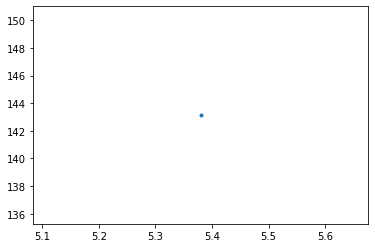

In [107]:
%matplotlib inline
inds = ~np.isnan(nearest_ota_array)
plt.plot(hail_size_data[inds], nearest_ota_array[inds], '.')

In [115]:
np.where(df_hail_no_repeats['MAGNITUDE'] == df_hail_no_repeats['MAGNITUDE'].max())

(array([12796]),)

In [31]:
date_time_data[120]

Timestamp('2018-04-03 20:13:00')

In [40]:
x = datetime(2019, 8, 18, 3, 59)
tor_lat = 43.91
tor_lon = -95.78

Timestamp('2018-01-11 21:57:00')

In [108]:
%matplotlib widget
cmap = cm.gist_earth
map_crs = ccrs.LambertConformal(central_longitude=-98,
                               central_latitude=35,
                               standard_parallels=(30, 60))
data_crs = ccrs.PlateCarree()

fig = plt.figure(1, figsize=(10,10))
ax = plt.subplot(1, 1, 1, projection=map_crs)
#ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], data_crs)
#ax.add_feature(cfeature.OCEAN, facecolor='lightskyblue') 
               #edgecolor='deepskyblue', linewidth=10)
#ax.add_feature(cfeature.LAKES, facecolor='lightskyblue', zorder=0)
#ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'], linewidth=1, edgecolor='k')
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1)

plt.contourf(lon, lat, BT_wnd, transform = ccrs.PlateCarree(), cmap = cmap)
#plt.colorbar()
#plt.scatter(lon[354, 155], lat[354, 155], transform = ccrs.PlateCarree(), s = 100)
#plt.scatter(lons, lats, s=100, transform = ccrs.PlateCarree(), color = 'r')
#plt.scatter(tor_lon, tor_lat,  marker = '*', transform = ccrs.PlateCarree(), s = 100, color = 'k')
plt.scatter(scat_lons, scat_lats, s=1, transform = ccrs.PlateCarree())
plt.scatter(lon[xis, yis], lat[xis, yis], transform = ccrs.PlateCarree(), color = 'r')
plt.scatter(df_hail_no_repeats['BEGIN_LON'][i], df_hail_no_repeats['BEGIN_LAT'][i],  marker = '*', transform = ccrs.PlateCarree(), s = 100, color = 'k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [70]:
df_hail['BEGIN_LAT'][i]

26.15

https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2021_c20220520.csv.gz


In [6]:
hail_datetimes = np.array([])

offset = [int(i[4]) for i in df_hail['CZ_TIMEZONE']]


for i in range(0,len(df_hail['BEGIN_TIME'])): 
    mtime        = str(np.array(df_hail['BEGIN_TIME'])[i])
    if len(mtime)<4:
        nz = 4 - len(mtime)
        nZ = '0'*nz
        mtime = nZ + mtime
    check_date = datetime(int(str(np.array(df_hail['BEGIN_YEARMONTH'])[i])[:4]), \
                     int(str(np.array(df_hail['BEGIN_YEARMONTH'])[i])[-2:]), \
                     int(str(np.array(df_hail['BEGIN_DAY'])[i])),           \
                     int(mtime[:-2]),     \
                     int(mtime[-2:])) + timedelta(hours = offset[i])
    hail_datetimes = np.append(hail_datetimes, check_date)

df_hail['Datetime'] = hail_datetimes
df_hail = df_hail.sort_values(by=['Datetime'], ignore_index = True)
hail_sizes = df_hail['MAGNITUDE']
hail_lats  = df_hail['BEGIN_LAT']
hail_lons  = df_hail['BEGIN_LON']

In [60]:
df_hail['Datetime'][700]

Timestamp('2021-03-31 23:26:00')

In [50]:
offset[i]

6

In [12]:
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import matplotlib.pyplot as plt

2021-05-02 15:39:00
OR_ABI-L1b-RadM1-M6C08_G16_s20211221535254_e20211221535311_c20211221535356
OR_ABI-L1b-RadM1-M6C08_G16_s20211221536254_e20211221536311_c20211221536353
OR_ABI-L1b-RadM1-M6C08_G16_s20211221537254_e20211221537311_c20211221537356
OR_ABI-L1b-RadM1-M6C08_G16_s20211221538254_e20211221538311_c20211221538361
OR_ABI-L1b-RadM1-M6C08_G16_s20211221539254_e20211221539311_c20211221539358
OR_ABI-L1b-RadM1-M6C08_G16_s20211221540283_e20211221540340_c20211221540384
OR_ABI-L1b-RadM1-M6C08_G16_s20211221541254_e20211221541311_c20211221541357
OR_ABI-L1b-RadM1-M6C08_G16_s20211221542254_e20211221542311_c20211221542363
OR_ABI-L1b-RadM1-M6C08_G16_s20211221543254_e20211221543311_c20211221543358


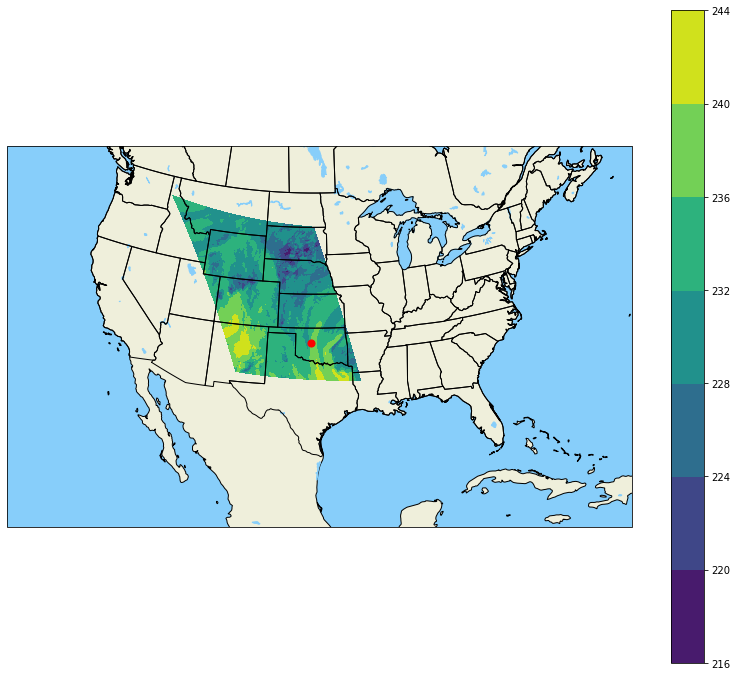

In [14]:

map_crs = ccrs.LambertConformal(central_longitude=-98,
                               central_latitude=35,
                               standard_parallels=(30, 60))
data_crs = ccrs.PlateCarree()

fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(1, 1, 1, projection=map_crs)
ax.set_extent([-125, -70, 20, 50], data_crs)
ax.add_feature(cfeature.OCEAN, facecolor='lightskyblue') 
               #edgecolor='deepskyblue', linewidth=10)
ax.add_feature(cfeature.LAKES, facecolor='lightskyblue', zorder=0)
ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'], linewidth=1, edgecolor='k')
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1)

plt.contourf(lon, lat, bt_wvp, transform = ccrs.PlateCarree())
plt.colorbar()
plt.scatter(hail_lons[i], hail_lats[i], transform = ccrs.PlateCarree(), s = 50, color = 'r')

In [10]:
## We're going to have a problem if the hail report is within 15 minutes of the start or end of an hour 



In [12]:
ds_vap

<xarray.Dataset>
Dimensions:                 (time: 9, x: 500, y: 500)
Coordinates:
    t                       (time) datetime64[ns] 2021-05-18T15:05:26.7419509...
  * y                       (y) float32 0.1198 0.1198 0.1197 ... 0.09192 0.09187
  * x                       (x) float32 -0.01397 -0.01392 ... 0.01392 0.01397
    y_image                 float32 0.1058
    x_image                 float32 0.0
Dimensions without coordinates: time
Data variables:
    planck_fk1              (time) float64 5.069e+04 5.069e+04 ... 5.069e+04
    planck_bc1              (time) float64 1.552 1.552 1.552 ... 1.552 1.552
    planck_fk2              (time) float64 2.332e+03 2.332e+03 ... 2.332e+03
    planck_bc2              (time) float64 0.9967 0.9967 ... 0.9967 0.9967
    Rad                     (time, y, x) float32 2.418 2.411 ... 2.702 2.724
    goes_imager_projection  (time) int32 -2147483647 -2147483647 ... -2147483647
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    production_environment:    OE
    spatial_resolution:        2km at nadir
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    orbital_slot:              GOES-East
    platform_ID:               G16
    instrument_type:           GOES R Series Advanced Baseline Imager
    scene_id:                  Mesoscale
    instrument_ID:             FM1
    title:                     ABI L1b Radiances
    summary:                   Single emissive band ABI L1b Radiance Products...
    keywords:                  SPECTRAL/ENGINEERING > INFRARED WAVELENGTHS > ...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Ear...
    iso_series_metadata_id:    a70be540-c38b-11e0-962b-0800200c9a66
    license:                   Unclassified data.  Access is restricted to ap...
    processing_level:          National Aeronautics and Space Administration ...
    cdm_data_type:             Image
    dataset_name:              OR_ABI-L1b-RadM1-M6C08_G16_s20211381505238_e20...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 6
    date_created:              2021-05-18T15:05:33.6Z
    time_coverage_start:       2021-05-18T15:05:23.8Z
    time_coverage_end:         2021-05-18T15:05:29.6Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        76379799-e321-4ed6-ab1b-f70ceea9322f

In [34]:
df_hail.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'Datetime'],
      dtype='object')

0       CST-6
1       CST-6
2       CST-6
3       CST-6
4       MST-7
        ...  
6262    EST-5
6263    EST-5
6264    EST-5
6265    EST-5
6266    EST-5
Name: CZ_TIMEZONE, Length: 6267, dtype: object

In [9]:

# datt = df_hail['Datetime'].astype('object')
# lats = df_hail['BEGIN_LAT']
# lons = df_hail['BEGIN_LON']

# datetime_no_repeats = np.array([])
# lat_no_repeats      = np.array([])
# lon_no_repeats      = np.array([])
# indices             = np.array([])

# t = 0

# for i in range(298, 299): ## while x:
#     #print(i)
#     dtime = 15
#     within_minutes = np.where((datt >= datt[i] - timedelta(minutes = 0)) & (datt < datt[i] + timedelta(minutes = 2*dtime)))[0]
#     #print(within_minutes.shape)
#     mag_list,lat_list, lon_list, date_list, dist_list, index_list = np.array([]),np.array([]),np.array([]),np.array([]), np.array([]), np.array([])
#     case_latlon = (lats[i], lons[i])
    
#     for j in within_minutes:
        
#         delta_d = 90
        
#         if distance.distance(case_latlon, (lats[j], lons[j])).km < delta_d: ## Checking if case is within 25km of the case in question
        
#             mag_list  = np.append(mag_list, df_hail['MAGNITUDE'][j])
#             index_list= np.append(index_list, j)
#             lat_list  = np.append(lat_list, lats[j])
#             lon_list  = np.append(lon_list, lons[j])
#             date_list = np.append(date_list, datt[i])
#             dist_list = np.append(dist_list, distance.distance(case_latlon, (lats[j], lons[j])).km)
    
#     if lat_list.shape != within_minutes.shape:
#         print(i)
#         print(within_minutes.shape)
    
#     max_w = np.where(mag_list == mag_list.max())[0]
#     df_index = index_list[max_w][0]

    
#     ## Delete hail reports within temporal/distance threshold
    

    
#     if  not (datt[df_index] in datetime_no_repeats):
#         #print('adding data point')

#         datetime_no_repeats = np.append(datetime_no_repeats, datt[df_index])
#         lat_no_repeats      = np.append(lat_no_repeats, lats[df_index])
#         lon_no_repeats      = np.append(lon_no_repeats, lons[df_index])
#         indices             = np.append(indices, df_index)

    
#     t += 1

In [16]:
merra_file = '/data/jtrapp/a/jamessg3/MERRA2/MERRA2_400.inst1_2d_asm_Nx.2021.nc4'

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 576, time: 24)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-01-01T23:00:00
Data variables:
    DISPH    (time, lat, lon) float32 ...
    PS       (time, lat, lon) float32 ...
    QV10M    (time, lat, lon) float32 ...
    QV2M     (time, lat, lon) float32 ...
    SLP      (time, lat, lon) float32 ...
    T10M     (time, lat, lon) float32 ...
    T2M      (time, lat, lon) float32 ...
    TO3      (time, lat, lon) float32 ...
    TOX      (time, lat, lon) float32 ...
    TQI      (time, lat, lon) float32 ...
    TQL      (time, lat, lon) float32 ...
    TQV      (time, lat, lon) float32 ...
    TROPPB   (time, lat, lon) float32 ...
    TROPPT   (time, lat, lon) float32 ...
    TROPPV   (time, lat, lon) float32 ...
    TROPQ    (time, lat, lon) float32 ...
    TROPT    (time, lat, lon) float32 ...
    TS       (time, lat, lon) float32 ...
    U10M     (time, lat, lon) float32 ...
    U2M      (time, lat, lon) float32 ...
    U50M     (time, lat, lon) float32 ...
    V10M     (time, lat, lon) float32 ...
    V2M      (time, lat, lon) float32 ...
    V50M     (time, lat, lon) float32 ...
Attributes:
    History:                           Original file generated: Fri Feb 12 06...
    Comment:                           GMAO filename: d5124_m2_jan10.inst1_2d...
    Filename:                          MERRA2_400.inst1_2d_asm_Nx.20210101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    SpatialCoverage:                   global
    VersionID:                         5.12.4
    TemporalRange:                     1980-01-01 -> 2016-12-31
    identifier_product_doi_authority:  http://dx.doi.org/
    ShortName:                         M2I1NXASM
    GranuleID:                         MERRA2_400.inst1_2d_asm_Nx.20210101.nc4
    ProductionDateTime:                Original file generated: Fri Feb 12 06...
    LongName:                          MERRA2 inst1_2d_asm_Nx: 2d,3-Hourly,In...
    Title:                             MERRA2 inst1_2d_asm_Nx: 2d,3-Hourly,In...
    SouthernmostLatitude:              -90.0
    NorthernmostLatitude:              90.0
    WesternmostLongitude:              -180.0
    EasternmostLongitude:              179.375
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4_p26_SLES12_M2...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/3Z173KIE2TPD
    RangeBeginningDate:                2021-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2021-01-01
    RangeEndingTime:                   23:00:00.000000

In [6]:
hail_days_array = np.array([i.strftime('%Y-%m-%d') for i in df_hail['Datetime']])
hail_days_nr    = np.array([i.strftime('%Y-%m-%d') for i in df_hail_no_repeats['Datetime']])

hail_days_array_unique = np.unique(hail_days_array)

In [23]:
param = 0
for i in hail_days_array_unique: 
    hail_size = np.where(hail_days_array == i)[0].shape[0]
    nr_size   = np.where(hail_days_nr == i)[0].shape[0]
    
    check = hail_size - nr_size
    print(check)
    if check>param: 
        param = check
        print(hail_size)
        print(nr_size)
        print(i)

0
0
2
5
3
2018-01-19
5
10
5
2018-01-21
4
1
4
4
0
0
0
0
1
0
6
12
6
2018-02-25
0
0
0
4
2
3
1
13
18
5
2018-03-10
34
61
27
2018-03-11
0
0
28
47
69
22
2018-03-18
45
71
98
27
2018-03-20
2
0
11
11
22
5
7
1
0
108
160
52
2018-04-03
20
73
9
0
5
0
115
171
56
2018-04-13
38
7
5
1
1
19
4
0
0
0
0
13
8
102
74
28
5
11
8
6
2
5
43
16
12
23
102
122
216
94
2018-05-15
22
23
26
80
34
14
34
20
21
25
30
37
62
108
29
40
46
15
13
12
3
56
28
46
31
14
29
47
59
15
53
15
9
2
128
173
45
2018-06-19
12
8
25
18
32
15
16
41
28
42
37
12
2
34
10
0
0
0
10
1
16
1
3
3
0
0
2
8
6
25
59
99
22
14
3
28
21
41
22
45
38
10
15
4
16
3
11
47
29
25
5
1
3
7
9
23
7
12
18
7
5
1
0
4
18
8
6
14
19
44
3
0
14
22
17
0
4
0
3
0
4
1
4
3
0
0
7
0
0
8
0
4
0
0
0
9
0
0
4
3
0
1
3
1
1
0
4
2
4
5
1
0
0
0
0
0
0
13
10
2
0
2
6
0
16
0
1
0
0
0
12
0
0
1
0
0
4
1
0
2
0
1
0
1
9
13
0
10
0
6
52
3
5
0
0
10
23
61
35
0
18
8
9
6
3
16
2
20
37
10
2
0
17
1
40
20
6
32
62
0
1
0
12
17
4
0
9
3
6
17
31
34
15
29
16
47
67
77
7
14
17
2
0
19
4
35
25
105
34
16
45
36
5
71
37
37
56
53
22

In [88]:
big_where = np.where(hail_days_array == '2019-05-28')[0]
little_where = np.where(hail_days_nr == '2019-05-28')[0]

In [89]:
big_lats = df_hail['BEGIN_LAT'][big_where]
big_lons = df_hail['BEGIN_LON'][big_where]

little_lats = df_hail_no_repeats['BEGIN_LAT'][little_where]
little_lons = df_hail_no_repeats['BEGIN_LON'][little_where]

In [101]:
%matplotlib widget
map_crs = ccrs.LambertConformal(central_longitude=-98,
                               central_latitude=35,
                               standard_parallels=(30, 60))
data_crs = ccrs.PlateCarree()

fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(1, 1, 1, projection=map_crs)
ax.set_extent([big_lons.min(), big_lons.max(), big_lats.min(), big_lats.max()], data_crs)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1)

plt.scatter(big_lons, big_lats, transform = ccrs.PlateCarree(), s = 20, color = 'r')
plt.scatter(little_lons, little_lats, transform = ccrs.PlateCarree(), s = 10, color = 'b')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [59]:
for i in range(0, len(df_hail_no_repeats['Datetime'][little_where])):

    if np.array(df_hail_no_repeats['BEGIN_LAT'])[little_where][i]<35.2:
        print(np.array(df_hail_no_repeats['Datetime'][little_where])[i])

2019-05-28T20:12:00.000000000
2019-05-28T21:18:00.000000000
2019-05-28T22:01:00.000000000
2019-05-28T22:31:00.000000000
2019-05-28T23:11:00.000000000
2019-05-28T23:42:00.000000000
